In [28]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rioxarray as rxr
import rasterio as rio
import geopandas as gpd
import seaborn as sns
import xarray as xr
import pandas as pd
import os

In [29]:
folder = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/'
PS_path_1 = folder + 'c4_ps_psscene_analytic_8b_sr_udm2/PSScene/20230911_165901_94_227a_3B_AnalyticMS_SR_8b_clip.tif'
PS_path_2 = folder + 'c4_ps_psscene_analytic_8b_sr_udm2/PSScene/20230911_162323_46_24cf_3B_AnalyticMS_SR_8b_clip.tif'
BSL = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/23_BSL/big_spirit_lake.shp'
output_data = folder + 'GP_GP_Final/'
output_mosaic = folder + 'GP_GP_Final/PS_mosaic.tif'
PS_final = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/PS_mosaic.tif'
PS_idw = output_data + 'PS_IDW.tif'

In [30]:
def PS_NDCI(dir,
             shape,
             plot = False,
             save = False):
    
    SP = gpd.read_file(shape)
    shape = SP.to_crs(32615)
    PS_raster = rxr.open_rasterio(dir, masked = True)
    red = PS_raster.sel(band=6)
    red_edge = PS_raster.sel(band=7)
    
    clipped_red = red.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
    clipped_red_edge = red_edge.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False) 
    
    
    NDCI = (clipped_red_edge - clipped_red) / (clipped_red_edge + clipped_red) 
    
    if plot == True:
        NDCI.plot(
            cmap = 'gnuplot',
            vmax = .25,
            vmin = .12)
        
        plt.title(f"PlanetScope Big Spirit Lake NDCI")
   
    if save == True:
        outname = f"PlanetScope_BSL_NDCI.tif"
        NDCI.rio.to_raster(os.path.join(output_data, outname), driver='GTIFF')
    
    return NDCI

In [44]:
raster_1 = rio.open(PS_path)
raster_2 = rio.open(PS_path_2)
Rlst = [raster_1, raster_2]

PS_mosaic, output = merge(Rlst)

In [46]:
output_meta = raster_1.meta.copy()
output_meta.update({
    'driver': 'Gtiff',
    'height': PS_mosaic.shape[1],
    'width': PS_mosaic.shape[2],
    'transform': output,
})

In [51]:
with rio.open(output_mosaic, 'w', **output_meta) as m:
    m.write(PS_mosaic)

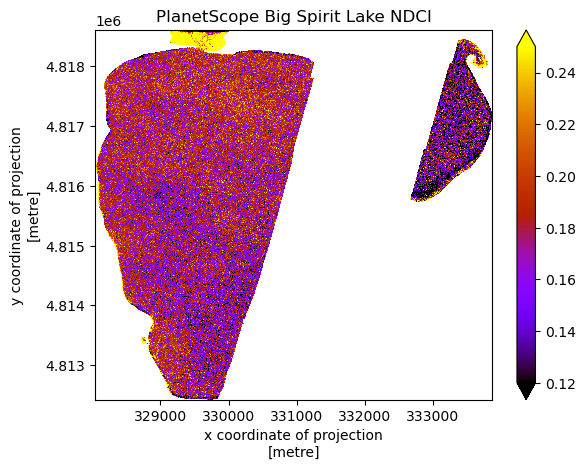

In [31]:
NDCI = PS_NDCI(PS_final,
              BSL,
               True,
               False
              )


In [32]:
NDCI_flat = NDCI.values.flatten()
NDCI_flat = NDCI_flat[~np.isnan(NDCI_flat)]
NDCI_filtered = NDCI_flat[(NDCI_flat >= -1) & (NDCI_flat <= 1)]

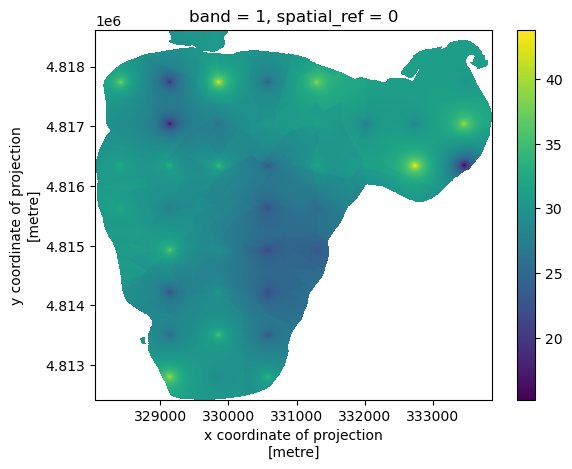

In [24]:
idw = rxr.open_rasterio(PS_idw)
shapei = gpd.read_file(BSL)
shape = shapei.to_crs(32615)
clipped_idw = idw.rio.clip(shape.geometry.values,
                                shape.crs,
                                all_touched = False,
                                drop = True,
                                invert = False)
clipped_idw.squeeze().plot.imshow(interpolation='none')

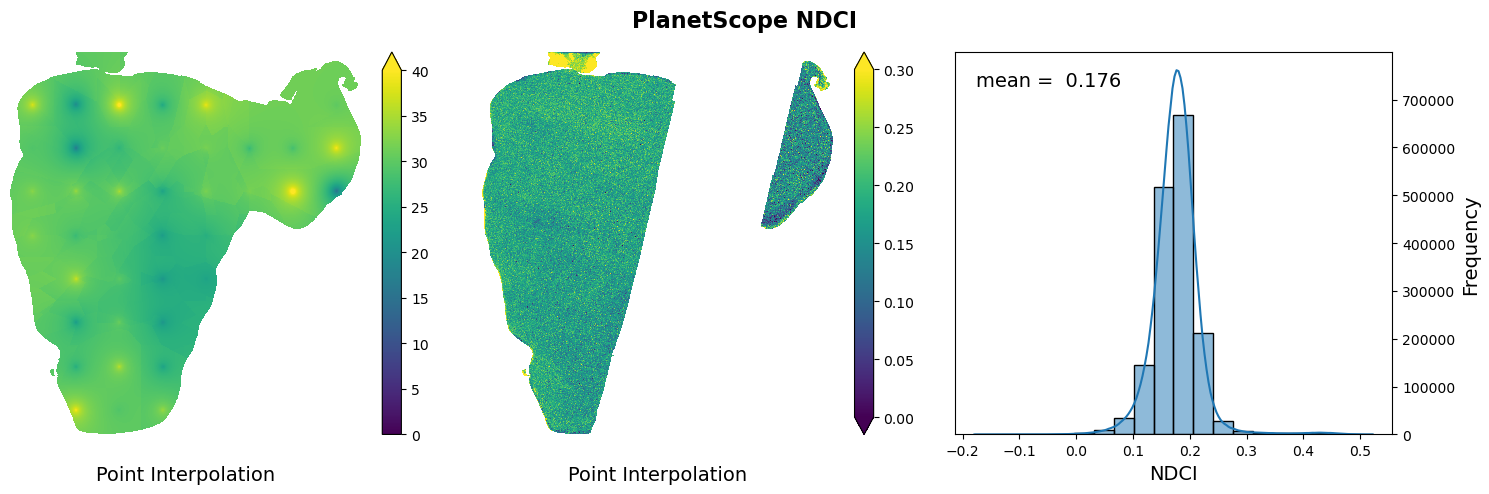

In [36]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,5))
mean = np.mean(NDCI_flat)   
a = NDCI 
b = clipped_idw

b.squeeze().plot.imshow(cmap = 'viridis', 
                        vmax=40, 
                        vmin=0, 
                        ax=ax0)
ax0.axis('off')
ax0.set_title("Point Interpolation", y=0, pad=-22, verticalalignment="top", fontsize=14)

a.squeeze().plot.imshow(cmap = 'viridis',
              vmax =.3, 
              vmin = 0, 
              ax=ax1)
ax1.axis('off')
ax1.set_title("Point Interpolation", y=0, pad=-22, verticalalignment="top", fontsize=14)
sns.histplot(NDCI_flat, 
                 kde=True,
                 bins=20,
                 ax=ax2)
ax2.set_xlabel('NDCI', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
ax2.text(.05, .95, f'mean = {mean: .3f}', transform=ax2.transAxes, verticalalignment='top', fontsize=14)
    
    
fig.suptitle(f'PlanetScope NDCI', fontsize=16, fontweight = 'bold')
plt.tight_layout()
plt.savefig(os.path.join(output_data, f'PlanetScope_NDCI_fig'), dpi=1200, bbox_inches='tight')
plt.show()